In [88]:
import pandas as pd
import numpy as np
import selection
import weights
import btag
import root_pandas
import importlib
import jetmet
import hl

In [62]:
mc = ['TTJets']
corrections = ["jes_up", "jes_down", "tau_eup", "tau_edown"]

In [66]:
importlib.reload(selection)
importlib.reload(jetmet)
def event_selection():
    
    samples = {}
    for sample in mc:
        
        #!!!!!!! Careful with JER application before Tau?!
        
        if "TTJets" in sample: isTT = True
        else: isTT = False
            
        if "Run2011" in sample: isData = True
        else: isData = False
        
        path = "/eos/user/l/llayer/opendata_files/preselection_merged/" + sample + ".root"
        
        df, cut_flow = selection.event_selection(path, isData = isData, isTT = isTT)
    
        samples[sample + "_cent"] = df
        
        if isData == False:
            
            for c in corrections:
                df, cut_flow = selection.event_selection(path, isData = isData, isTT = isTT, corrLevel = c,
                                                        tau_factor = 0.1, jes_factor = 0.1)
                samples[sample + "_" + c] = df
        
        
    return samples

samples = event_selection()

Processing: TTJets.root isData: False isTT: True corrLevel cent
Processing: TTJets.root isData: False isTT: True corrLevel jes_up
SF 1.1 0.9
JESUP
Processing: TTJets.root isData: False isTT: True corrLevel jes_down
SF 1.1 0.9
Processing: TTJets.root isData: False isTT: True corrLevel tau_eup
SF 1.0 1.0
Processing: TTJets.root isData: False isTT: True corrLevel tau_edown
SF 1.0 1.0


In [89]:
def candidates(sample, df, invert_btag = False, njets=-1, scale_met=None, isData=False):

    df['nJets'] = df["Jet_pt"].str.len()
    
    # b-tagging
    df["Jet_nbtags"] = df["Jet_csvDisc"].apply( lambda x : btag.count_btags(x, njets=njets) )
    if invert_btag:
        df = btag.no_tag(df)
    else:
        df = btag.at_least_1tag(df)

    # MET cut
    if scale_met != None:
        df['MET_met'] = df['MET_met'] * scale_met
    df = selection.met_requirement(df)

    
    # HL features
    df = pd.concat([df, df.apply(lambda ev : pd.Series(hl.hlFeatures(ev, njets=njets)), axis=1)], axis=1)
    

    # MC weights
    if not isData:

        hlt_40, hlt_45 = weights.lumi()
        total_lumi = hlt_40 + hlt_45
        trigger_frac = hlt_40 / float(hlt_45)
        df = pd.concat([df, df.apply(lambda ev: pd.Series(btag.eval_sf_eff(ev)), axis=1)], axis=1)
        df["Jet_btag_weight1"] = df.apply(lambda ev : btag.b_weight_method1(ev, njets=njets), axis=1)
        #if (key == "central") | (key == "centJER"):
        #    df["Jet_btag_weight1_up"] = df.apply(lambda ev : btag.b_weight_method1(ev, syst='up', njets=njets), axis=1)
        #    df["Jet_btag_weight1_down"] = df.apply(lambda ev : btag.b_weight_method1(ev, syst='down', njets=njets), axis=1)
        #df["Jet_btag_weight2"] = df.apply(lambda ev : btag.b_weight_method2(ev, njets=njets), axis=1)
        # trigger weights
        #df["trigger_weight"] = df.apply(lambda ev : weights.trigger_weight(ev, trigger_frac), axis=1)
        df = pd.concat([df, df.apply(lambda ev: pd.Series(weights.trigger_weight(ev, trigger_frac)), axis=1)], axis=1)
        # normalization
        counts_path = "/eos/user/l/llayer/opendata_files/preselection_merged/" + sample + "_counts.root"
        total_counts = root_pandas.read_root(counts_path)
        xsec = weights.get_xsec(sample)
        weights.norm(df, total_counts, xsec, lumi = total_lumi)
        
        # PDF
        #if ("TTJets" in sample) & (key == "centJER"):
        #    pdf = pd.read_hdf("TTJets_pdfweights.h5")
        #    df = pd.merge(df, pdf, how="left", on=["event", "luminosityBlock", "run"])

    # QCD
    if isData & invert_btag:
        
        # Assume light flavour
        def lf(nJets):
            return np.zeros((nJets))
        df["Jet_flavour"] = df["nJets"].apply(lf)
        df = pd.concat([df, df.apply(lambda ev: pd.Series(btag.eval_sf_eff(ev)), axis=1)], axis=1)
        df["btag_weight"] = df.apply(lambda ev : btag.b_weight_method2(ev, njets=njets), axis=1)
        
    return df

In [90]:
def proc_candidates(samples, njets = -1):
    
    cand_samples = {}    
    
    for sample in mc:
        for key in ["cent"] + corrections:
            print( sample + "_" + key )
            df = samples[sample + "_" + key]
            cand_samples[sample + "_" + key] = candidates(sample, df)  

    #new_samples = rearrange_samples(cand_samples)
    return cand_samples

In [91]:
cands = proc_candidates(samples)
#print(cands)

TTJets_cent
TTJets_jes_up
TTJets_jes_down
TTJets_tau_eup
TTJets_tau_edown


In [92]:
features = ['ht', 'aplanarity', 'sphericity', 'chargeEta', 'met', 'deltaPhiTauMet', 'mt', 'mTauJet']
for sample in cands:
    cands[sample]["bdt"] = bdt.predict_proba(cands[sample][features].values)[:,0]    

In [70]:
import plot
import ROOT

In [106]:
variables = [
    {"var_name" : "bdt", "bins" : 15, "xlow" : 0., "xup" : 1., "xtitle" : "bdt"}
    #{"var_name" : "MET_met", "bins" : 30, "xlow" : 0., "xup" : 400, "xtitle" : "MET [GeV]"}
]

In [107]:
def vars_to_histos(samples, variables):
    file = ROOT.TFile("test_histos.root", 'recreate')
    for name, sample in samples.items():
        for var in variables:
            plot.save_var(sample, name, var["var_name"], var["bins"], var["xlow"], var["xup"])
    file.Close()

In [108]:
vars_to_histos(cands, variables)

TTJets_cent bdt None
TTJets_jes_up bdt None
TTJets_jes_down bdt None
TTJets_tau_eup bdt None
TTJets_tau_edown bdt None


In [109]:
f = ROOT.TFile("test_histos.root")

In [110]:
f.ls()

TFile**		test_histos.root	
 TFile*		test_histos.root	
  KEY: TH1D	TTJets_cent_bdt;1	TTJets_cent_bdt
  KEY: TH1D	TTJets_jes_up_bdt;1	TTJets_jes_up_bdt
  KEY: TH1D	TTJets_jes_down_bdt;1	TTJets_jes_down_bdt
  KEY: TH1D	TTJets_tau_eup_bdt;1	TTJets_tau_eup_bdt
  KEY: TH1D	TTJets_tau_edown_bdt;1	TTJets_tau_edown_bdt


In [111]:
var = variables[0]

In [112]:
hist_cent = f.Get("TTJets" + "_cent_" + var["var_name"])
hist_jes_up = f.Get("TTJets" + "_jes_up_" + var["var_name"])
hist_jes_down = f.Get("TTJets" + "_jes_down_" + var["var_name"])
hist_tau_eup = f.Get("TTJets" + "_tau_eup_" + var["var_name"])
hist_tau_edown = f.Get("TTJets" + "_tau_edown_" + var["var_name"])

In [115]:
#up = hist_jes_up
#down = hist_jes_down
cent = hist_cent
up = hist_tau_eup
down = hist_tau_edown

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


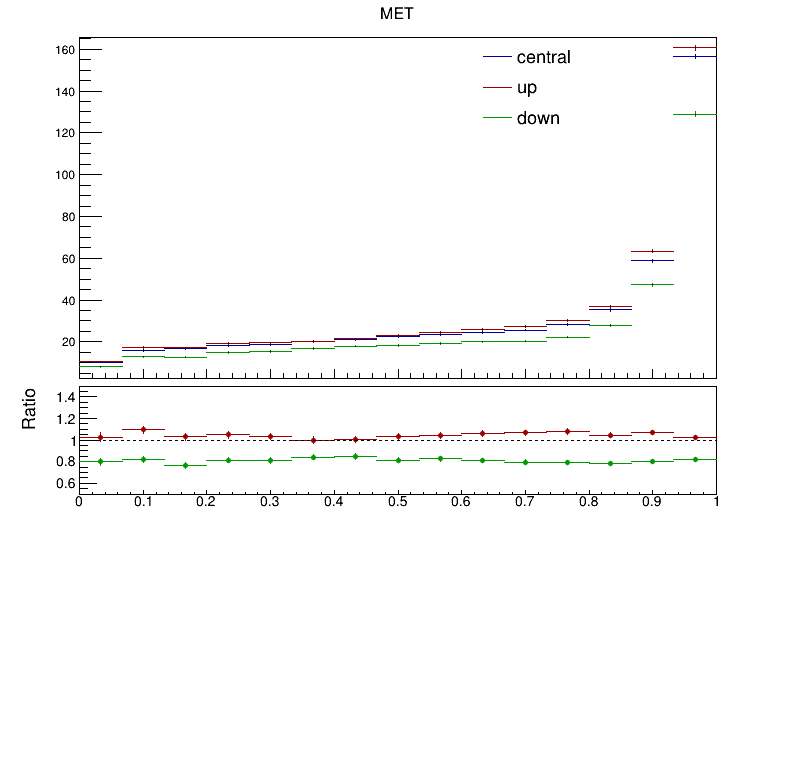

In [116]:
ROOT.gStyle.SetOptStat(0)

ratio_up = plot.createRatio(up, cent)
ratio_down = plot.createRatio(down, cent)

c, pad1, pad2 = plot.createCanvasPads()

# draw everything
pad1.cd()
cent.Draw()
up.Draw("SAME")
up.SetLineColor(ROOT.kRed+2)
down.Draw("SAME")
down.SetLineColor(ROOT.kGreen+2)

cent.SetTitle("MET")
leg = ROOT.TLegend(0.6, 0.65, .8, .89);
leg.AddEntry(cent, "central", "l");
leg.AddEntry(up, "up", "l");
leg.AddEntry(down, "down", "l");
leg.SetBorderSize(0)
leg.Draw("SAME")

pad2.cd()
ratio_up.Draw("ep")
ratio_up.SetLineColor(ROOT.kRed+2)
ratio_up.SetMarkerColor(ROOT.kRed+2)
ratio_down.Draw("epSAME")    
ratio_down.SetMarkerColor(ROOT.kGreen+2)
ratio_down.SetLineColor(ROOT.kGreen+2)
ratio_down.GetXaxis().SetTitle(var["xtitle"])

f1 = ROOT.TLine(0, 1., 1,1.)
f1.SetLineColor(ROOT.kBlack)
f1.SetLineStyle(ROOT.kDashed)
f1.Draw("same")

c.Draw()

In [85]:
import pickle

In [86]:
bdt = pickle.load(open("bdt/xgb.pkl", "rb"))